In [1]:
# Ensure torch is installed in this notebook environment

import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


Using device: cpu


In [2]:

DATA_PATH = "student_success_survey.csv"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

df.info()

(240, 25)
<class 'pandas.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   student_uid                          240 non-null    str    
 1   pillar                               240 non-null    str    
 2   current_term                         240 non-null    str    
 3   cgpa                                 231 non-null    float64
 4   prereq_ct_grade                      240 non-null    str    
 5   used_pytorch_tensorflow              240 non-null    str    
 6   used_big_data_tools                  240 non-null    str    
 7   diag_python_mod_answer               240 non-null    str    
 8   diag_pvalue_answer                   240 non-null    str    
 9   diag_pca_answer                      240 non-null    str    
 10  grit_distracted_by_new_ideas         240 non-null    int64  
 11  grit_setbacks_dont_discourage_me 

In [3]:
# Missing values per column
(df.isna().mean().sort_values(ascending=False) * 100).round(1).head(10)


commute_minutes_daily      6.2
cgpa                       3.8
hours_per_week_planned     3.3
student_uid                0.0
pillar                     0.0
used_pytorch_tensorflow    0.0
used_big_data_tools        0.0
current_term               0.0
prereq_ct_grade            0.0
diag_pvalue_answer         0.0
dtype: float64

## 3) Feature engineering (scaffold)

Create at least **two engineered features**.

Suggested ideas:
1. **Grit score**: average the grit items **with reverse‑coding where appropriate**.
2. **Technical readiness**: combine diagnostic correctness + experience.
3. **Time budget score**: e.g., `hours_per_week_planned - commute_minutes_daily/60`.

⚠️ Reverse-coded grit items in this dataset:
- `grit_distracted_by_new_ideas`
- `grit_short_term_obsession_then_loss`
- `grit_i_change_goals`

Reverse-coding rule for a 1–5 scale: `reversed = 6 - original`.


In [4]:
# TODO: Engineer at least TWO features.

GRIT_POS = [
    "grit_setbacks_dont_discourage_me",
    "grit_i_am_a_hard_worker",
    "grit_i_finish_what_i_begin"
]

GRIT_NEG = [
    "grit_distracted_by_new_ideas",
    "grit_short_term_obsession_then_loss",
    "grit_i_change_goals",
]

SELF_EFFICACY = [
    "cse_debug_python_without_help",
    "cse_learn_new_ml_library",
    "cse_explain_model_theory",
    "cse_interpret_complex_viz"
]

# Reverse-code the negative items
for col in GRIT_NEG:
    df[col + "_rev"] = 6 - df[col]

# Example engineered feature 1: average grit
df["avg_grit"] = df[GRIT_POS + [c + "_rev" for c in GRIT_NEG]].mean(axis=1)

# TODO: engineered feature 2 (pick one idea above)
df["tech_readiness"] = (
    (df["used_pytorch_tensorflow"] == "Yes").astype(int) +
    (df["diag_python_mod_answer"] == "2").astype(int)
)

df["time_budget"] = (
    (df["hours_per_week_planned"]) - (df["commute_minutes_daily"] / 60)
)

df["self_efficacy"] = (
    df[SELF_EFFICACY].mean(axis=1)
)

# Quick check
df[["avg_grit"]].describe().T
df[["tech_readiness"]].describe().T
df[["time_budget"]].describe().T
df[["self_efficacy"]].describe().T
print(df[["avg_grit", "tech_readiness", "time_budget", "self_efficacy"]].head())


   avg_grit  tech_readiness  time_budget  self_efficacy
0  3.500000               1     6.650000           3.50
1  2.666667               1     4.950000           3.50
2  2.666667               1     7.000000           4.50
3  2.000000               2     2.483333           3.00
4  3.166667               1     6.750000           4.25


## 4) Exploratory Data Analysis (EDA)

Answer these questions with visuals + 2–4 sentences each:

1. Does **grit** correlate with **planned hours per week**?
2. Is **CGPA** roughly linearly related to **final_course_score**?
3. Are there obvious group differences by `pillar`?

Tip: keep plots readable; label axes; include titles.


In [18]:
def plot_with_regression(df, x_col, y_col, title, x_label, y_label):
    # Select ONLY the columns needed for this specific plot
    # This prevents NaNs in other columns from affecting this calculation
    plot_df = df[[x_col, y_col, 'pillar']].copy().dropna(subset=[x_col, y_col])
    
    if plot_df.empty:
        print(f"Warning: No data available for {x_col} and {y_col}")
        return

    plt.figure(figsize=(8, 5))
    
    # Calculate Pearson Correlation for THIS specific data subset
    r_val, _ = pearsonr(plot_df[x_col], plot_df[y_col])
    
    # 1. Plot scatter points by pillar
    for p in pillars:
        subset = plot_df[plot_df['pillar'] == p]
        plt.scatter(subset[x_col], subset[y_col], 
                    label=p, color=PILLAR_COLORS.get(p, 'grey'), alpha=0.7)
    
    # 2. Linear Regression (Specific to this plot's data)
    m, c = np.polyfit(plot_df[x_col], plot_df[y_col], 1)
    
    # Create an array of x-values for a smooth line
    x_range = np.linspace(plot_df[x_col].min(), plot_df[x_col].max(), 100)
    plt.plot(x_range, m * x_range + c, color='black', 
             linestyle='--', linewidth=2, label=f'Trendline (r={r_val:.2f})')

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{title} (Pearson r = {r_val:.2f})")
    plt.grid(False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    
# To check if data is different for 4.1 and 4.2
print(f"Grit variance: {df['avg_grit'].var()}")
print(f"CGPA variance: {df['cgpa'].var()}")

Grit variance: 0.6760402138540215
CGPA variance: 0.20446911349520044


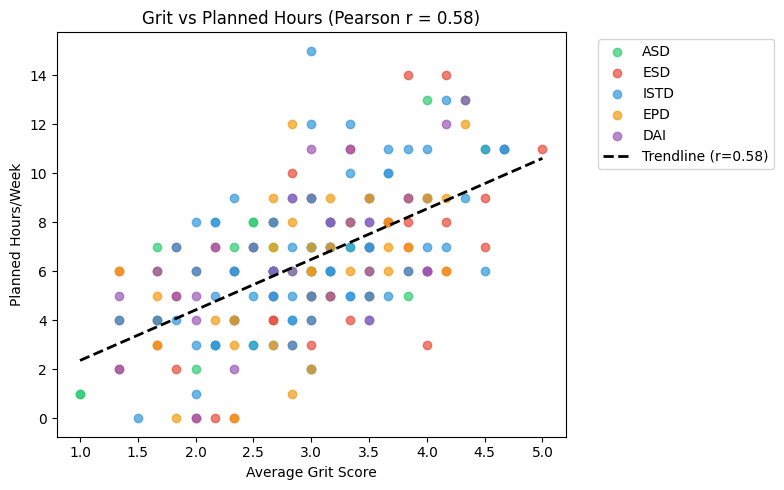

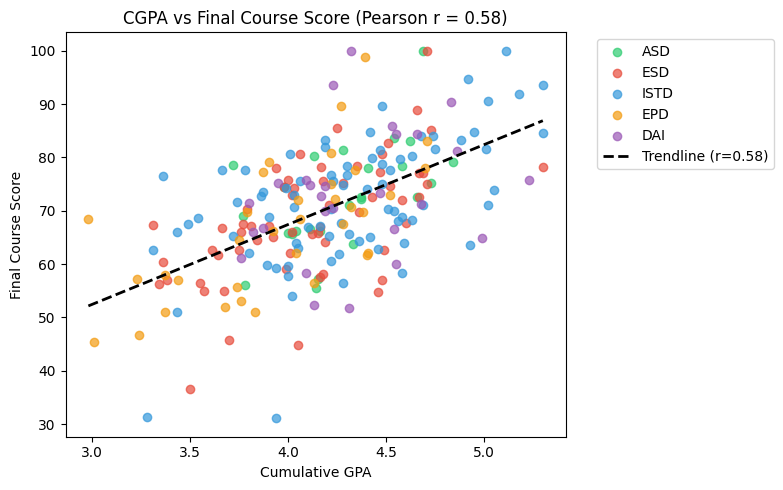

C:\Users\daji daji\AppData\Local\Temp\ipykernel_23016\1737685759.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(box_data, labels=pillars, patch_artist=True, medianprops={'color': 'black'})


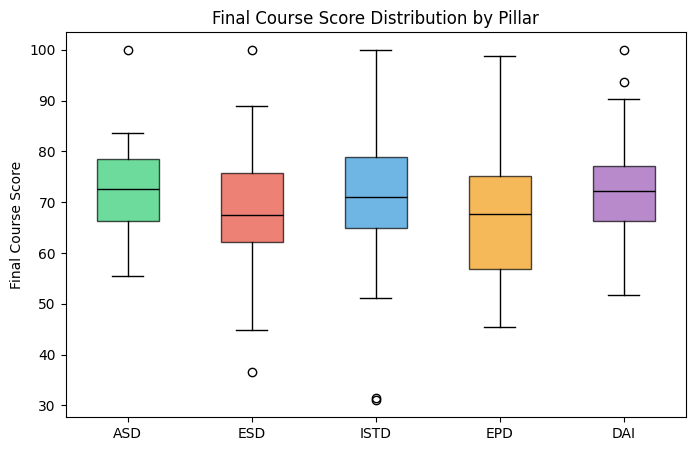

In [19]:
# 4.1 Grit vs hours
plot_with_regression(df, "avg_grit", "hours_per_week_planned", 
                     "Grit vs Planned Hours", "Average Grit Score", "Planned Hours/Week")

# 4.2 CGPA vs final score
plot_with_regression(df, "cgpa", "final_course_score", 
                     "CGPA vs Final Course Score", "Cumulative GPA", "Final Course Score")

# 4.3 Group Differences by Pillar (Boxplot for clear group comparison)
plt.figure(figsize=(8, 5))
box_data = [df[df['pillar'] == p]['final_course_score'].dropna() for p in pillars]
bp = plt.boxplot(box_data, labels=pillars, patch_artist=True, medianprops={'color': 'black'})
for patch, pillar in zip(bp['boxes'], pillars):
    patch.set_facecolor(PILLAR_COLORS[pillar])
    patch.set_alpha(0.7)
plt.title("Final Course Score Distribution by Pillar")
plt.ylabel("Final Course Score")
plt.grid(False)
plt.show()

### Grit vs Planned Hours

The scatter plot suggests that there is some positive correlation between the grit and planned hours of students, suggesting that students with higher grit scores tend to commit more time to their studies as they may feel more motivated to study. Given an relation coefficient (r) of 0.58, there is moderate positive correlation between grit and planned hours, suggesting that grit may influence how many hours each student puts into studying. There are no visibly significant differences between different pillars.

### CGPA vs Final Score

The scatter plot suggests that there is some positive correlation between the CGPA and final course scores, suggesting that students with higher CGPA tend to also score well for finals. Given an relation coefficient (r) of 0.58, there is moderate positive correlation between CGPA and final scores, suggesting that students tend to perform pretty consistently throughout their studies. There are no visibly significant differences between different pillars.

### Pillar Distribution of Final Scores

Based on the box-and-wiskers plot, the average (median) of the final course scores typically hover about the same range between 65-75 across all pillars. However, the range of scores within each pillar is smaller for ASD and DAI, while ESD, EPD and ISTD have wider range of scores and more extreme points (outliers). This could be attributed to the smaller cohort size for ASD and DAI, where the probabilities of students having different levels of skillsets are higher in the more populated pillars.